In [1]:
import pandas as pd
import tensorflow as tf
import numpy
import pickle as pkl
import os
os.chdir(os.path.join(os.getcwd(), ".."))
import finviz as fz
import yfinance as yf
import calendar
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, log_loss
from sklearn.metrics import PrecisionRecallDisplay

from src.utils import data_layer, get_dataset, hist_multi_plot

%load_ext autoreload
%autoreload 2

In [2]:
perc_space = 0.8
perc_time = 0.8

WINDOW_SIZE = 21 # Include window + target
BATCH_SIZE = 8

data_path = os.path.join(os.getcwd(), "data")
sp_100_file = os.path.join(data_path, "sp-100-index-07-02-2020.csv")

# Load and Data formatting

In [3]:
stock = data_layer(sp_100_file, data_path, perc_space, perc_time)

BKNG <class 'IndexError'> list index out of range
BRK.B <class 'requests.exceptions.HTTPError'> 404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=BRK.B
C <class 'IndexError'> list index out of range
DD <class 'IndexError'> list index out of range
EXC <class 'IndexError'> list index out of range
GOOGL <class 'IndexError'> list index out of range
GS <class 'IndexError'> list index out of range
MO <class 'IndexError'> list index out of range
RTX <class 'IndexError'> list index out of range


In [4]:
n_train_space = int(len(stock.keys())*perc_space)
n_train_out_space = len(stock.keys())-n_train_space

In [5]:
train_space = np.random.choice(list(stock.keys()), size=n_train_space, replace=False).tolist()
test_space = list(set(stock.keys()) - set(train_space))
samples = stock["AAPL"].shape[0]
train_samples = int((samples-WINDOW_SIZE)*perc_time)

# Data loader object

In [6]:
train_ds, val_ds = get_dataset(stock, train_space, train_samples=train_samples, window_size=WINDOW_SIZE)

Companies:  ['BK', 'DHR', 'JPM', 'PM', 'GILD', 'LLY', 'BMY', 'BLK', 'LMT', 'SO', 'CAT', 'GD', 'MRK', 'NVDA', 'MS', 'WFC', 'COST', 'ALL', 'PEP', 'EMR', 'MA', 'MSFT', 'DOW', 'MET', 'USB', 'PG', 'DIS', 'CSCO', 'MCD', 'AXP', 'CHTR', 'NEE', 'AIG', 'ADBE', 'SBUX', 'CMCSA', 'ABBV', 'XOM', 'ABT', 'V', 'WMT', 'PFE', 'PYPL', 'BAC', 'HON', 'TMO', 'AMGN', 'FB', 'KMI', 'TXN', 'HD', 'JNJ', 'OXY', 'AAPL', 'CL', 'MMM', 'VZ', 'MDLZ', 'UNP', 'GOOG', 'TGT', 'NKE', 'T', 'F', 'COF', 'UNH', 'GM', 'CRM', 'DUK', 'MDT', 'LOW', 'KO', 'NFLX']


In [7]:
test_ds = get_dataset(stock, test_space, train_samples=None, window_size=WINDOW_SIZE)

Companies:  ['CVS', 'GE', 'CVX', 'FDX', 'WBA', 'KHC', 'SLB', 'BA', 'AMZN', 'COP', 'IBM', 'UPS', 'QCOM', 'ACN', 'ORCL', 'SPG', 'INTC', 'AMT', 'BIIB']


In [8]:
train_ds = train_ds.shuffle(buffer_size=8000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(16)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Model

In [9]:
def build_model():
    inputs = tf.keras.Input(shape=(20,10))
    x = tf.keras.layers.BatchNormalization(axis=2)(inputs)
    x_0 = tf.keras.layers.GRU(64, return_sequences=False)(x)
    x_1 = tf.keras.layers.GRU(64, return_sequences=False)(x)
    x = tf.keras.layers.Concatenate()([x_0, x_1])
    x = tf.keras.layers.BatchNormalization()(x)
    sigmoids = tf.keras.layers.Dense(3, activation="sigmoid")(x)
    outputs = tf.keras.backend.expand_dims(sigmoids, axis=1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 10)       40          input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 64)           14592       batch_normalization[0][0]        
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 64)           14592       batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
model.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC", tf.keras.metrics.AUC(curve="PR", name="PR_AUC")])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',#val_loss
                                               patience=2,
                                               mode='min',
                                               restore_best_weights=True)

In [12]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=20, 
                    callbacks = [es_callback])

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1689/1689 [==============================] - 24s 14ms/step - loss: 0.1568 - accuracy: 0.1054 - auc: 0.6961 - PR_AUC: 0.0764 - val_loss: 0.1134 - val_accuracy: 0.0610 - val_auc: 0.8163 - val_PR_AUC: 0.2772
Epoch 2/20
1689/1689 [==============================] - 25s 15ms/step - loss: 0.1209 - accuracy: 0.0728 - auc: 0.7534 - PR_AUC: 0.1636 - val_loss: 0.1107 - val_accuracy: 0.0442 - val_auc: 0.8219 - val_PR_AUC: 0.2806
Epoch 3/20
1689/1689 [==============================] - 33s 20ms/step - loss: 0.1194 - accuracy: 0.0793 - auc: 0.7683 - PR_AUC: 0.1645 - val_loss: 0.1173 - val_accuracy: 0.0456 - val_auc: 0.7783 - val_PR_AUC: 0.2440
Epoch 4/20
1689/1689 [==============================] - 30s 18ms/step - loss: 0.1183 - accuracy: 0.0777 - auc: 0.7789 - PR_AUC: 0.1724 - val_loss: 0.1133 - val_accuracy: 0.0476 - val_auc: 0.7998 - val_PR_AUC: 0.2748


In [13]:
model.evaluate(test_ds)

554/554 [==============================] - 2s 4ms/step - loss: 0.1020 - accuracy: 0.0341 - auc: 0.7053 - PR_AUC: 0.0831


[0.10203111916780472,
 0.034108877182006836,
 0.7053048014640808,
 0.08308228850364685]

# Comparing predictions and looking if it is learning anything
dataframe start from the 20, example df[20:] are all the samples in test, and each company has ~232 records, so to iterate would be accooording to 232 and addding 20 to the origiinal df

In [14]:
y_test = []
for sample in test_ds:
    y_test.append(sample[1].numpy())
y_test = np.squeeze(np.concatenate(y_test))

In [15]:
out = model.predict(test_ds)
out = np.squeeze(out)
aux_stock = {}
cont = 0
for idx, company in enumerate(test_space):
    print("Company: ", company)
    curr_hist = stock[company]
    curr_index = curr_hist.index[WINDOW_SIZE-1:]
    curr_size = len(curr_index)
    pred_df = pd.DataFrame(out[cont:cont+curr_size],
                           index=curr_hist.index[WINDOW_SIZE-1:],
                           columns=["Pred_Buy", "Pred_Option", "Pred_Sale"])
    aux_stock[company] = stock[company].merge(pred_df, how="left", 
                                              left_index=True, right_index=True)
    cont = cont + curr_size

Company:  CVS
Company:  GE
Company:  CVX
Company:  FDX
Company:  WBA
Company:  KHC
Company:  SLB
Company:  BA
Company:  AMZN
Company:  COP
Company:  IBM
Company:  UPS
Company:  QCOM
Company:  ACN
Company:  ORCL
Company:  SPG
Company:  INTC
Company:  AMT
Company:  BIIB


In [16]:
df = pd.DataFrame(np.concatenate([out, y_test], axis=1), 
             columns=["pred_Buy", "pred_Option", "pred_Sale", "Buy", "Option", "Sale"])

In [18]:
means = df.mean()

# Metrics

Average Precision:  0.057022820331023044
Strawman Crossentropy 0.05152081841528123
Binary Crossentropy 0.05192341070003428


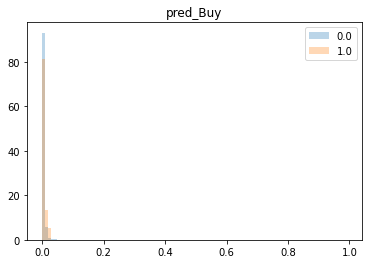

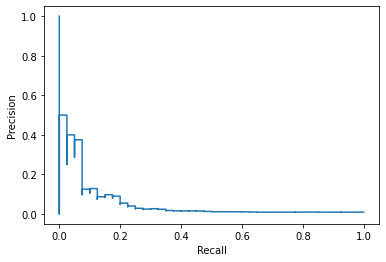

In [20]:
pred_col = "pred_Buy"
col = "Buy"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

Average Precision:  0.07245711868426902
Strawman Crossentropy 0.09756401351977914
Binary Crossentropy 0.10097153538769067


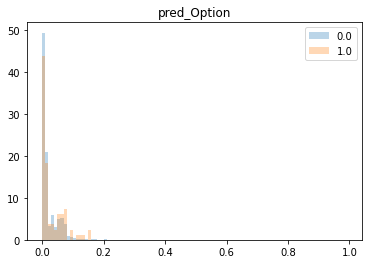

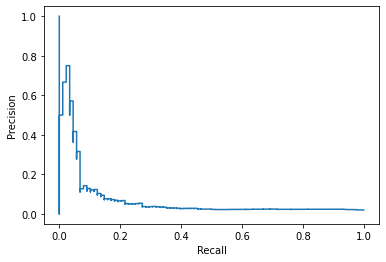

In [21]:
pred_col = "pred_Option"
col = "Option"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

Average Precision:  0.10938126804617525
Strawman Crossentropy 0.16137010209226896
Binary Crossentropy 0.15319940491028294


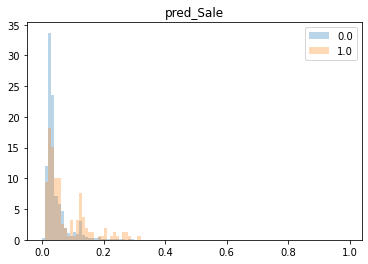

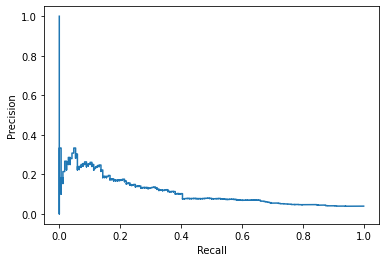

In [22]:
pred_col = "pred_Sale"
col = "Sale"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision)
strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)